<a href="https://colab.research.google.com/github/SivenM/unet_test/blob/master/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ноутбук для Unet. 

Генераторы, модель, обучение и тестирование проводится здесь. 

Датасет взят из:
https://supervise.ly/explore/projects/supervisely-person-dataset-23304/datasets

и хранится в gdrive (unet_dataset).

##Получим доступ к gdrive и загруим датасет в среду.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


##Выбираем tensorflow 2.x

In [0]:
 %tensorflow_version 2.x


TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
print(tf.__version__)

2.1.0


##Пути для данных

In [0]:
#пути для тренироваочных изображений и масок
img_train_dir = '/content/gdrive/My Drive/unet_dataset/train/images' 
mask_train_dir = '/content/gdrive/My Drive/unet_dataset/train/masks'

#пути для проверочных изображений и масок
img_val_dir = '/content/gdrive/My Drive/unet_dataset/validation/images' 
mask_val_dir = '/content/gdrive/My Drive/unet_dataset/validation/masks'

#пути для тестовых данных
img_test_dir = '/content/gdrive/My Drive/unet_dataset/test/images' 
mask_test_dir = '/content/gdrive/My Drive/unet_dataset/test/masks'



##Метрика качества Intersection over Union


![alt text](https://konspekta.net/megaobuchalkaru/imgbaza/baza12/331634881896.files/image103.png)

##Архитектура нейронной сети:

![alt text](https://raw.githubusercontent.com/zhixuhao/unet/master/img/u-net-architecture.png)

##Модель unet

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from google.colab import files
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras import optimizers


input_tensor = Input(shape=(512,512,1))
conv1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_tensor)
conv1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = layers.Dropout(0.5)(conv4)
pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = layers.Dropout(0.5)(conv5)

up6 = layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(drop5))
merge6 = layers.concatenate([drop4,up6], axis = 3)
conv6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv6))
merge7 = layers.concatenate([conv3,up7], axis = 3)
conv7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv7))
merge8 = layers.concatenate([conv2,up8], axis = 3)
conv8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv8))
merge9 = layers.concatenate([conv1,up9], axis = 3)
conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = layers.Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = layers.Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input_tensor, conv10)

miou = tf.keras.metrics.MeanIoU(num_classes=2)
model.compile(loss= 'binary_crossentropy', 
                optimizer= optimizers.Adam(lr=1.3e-4),                 
                metrics=['acc', miou])


In [0]:
model.summary()

#Генераторы для данных:

train_generator - генератор для тренировочных данных

val_generator - генератор для проверочных данных

test_generator - генератор для контрольных данных


In [0]:
def train_generator(img_train_dir, mask_train_dir):
  train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)
  

  img_train_generator = train_datagen.flow_from_directory(
        img_train_dir,
        target_size=(512,512),
        batch_size=5,
        #classes=['images/image'],
        color_mode="grayscale",
        seed=1,
        class_mode=None,)

  mask_train_generator = train_datagen.flow_from_directory(
        mask_train_dir,
        target_size=(512,512),
        batch_size=5,
        #classes=['masks/mask'],
        color_mode="grayscale",
        seed=1,
        class_mode=None,)
  train_gen = zip(img_train_generator, mask_train_generator)
  for (img, mask) in train_gen:
    mask[mask > 0.9] = 1
    mask[mask <= 0.9] = 0
    yield (img,mask)
  
#train_gen = (pair for pair in zip(img_train_generator, mask_train_generator))

def val_generator(img_val_dir, mask_val_dir):
  val_datagen = ImageDataGenerator(rescale=1./255)
  img_val_generator = val_datagen.flow_from_directory(
        img_val_dir,
        target_size=(512,512),
        batch_size=5,
        #classes=['images/image'],
        color_mode="grayscale",
        seed=1,
        class_mode=None,)

  mask_val_generator = val_datagen.flow_from_directory(
        mask_val_dir,
        target_size=(512,512),
        batch_size=5,
        #classes=['masks/mask'],
        color_mode="grayscale",
        seed=1,
        class_mode=None,)
        
  val_gen = zip(img_val_generator, mask_val_generator)
  for (img, mask) in val_gen:
    mask[mask == 1] = 1
    mask[mask <= 1] = 0
    yield (img,mask)
#val_gen = (pair for pair in zip(img_val_generator, mask_val_generator))


def test_generator(img_test_dir, mask_test_dir):
  test_datagen = ImageDataGenerator(rescale=1./255)
  test_img_generator = test_datagen.flow_from_directory(
      img_test_dir,
      target_size =(512,512),
      batch_size = 2,
      color_mode="grayscale",
      class_mode=None
  )
  test_mask_generator = test_datagen.flow_from_directory(
      mask_test_dir,
      target_size =(512, 512),
      batch_size=2,
      color_mode="grayscale",
      class_mode=None 
  )
  test_gen = zip(test_img_generator, test_mask_generator)
  for (img, mask) in test_gen:
      mask[mask > 0.5] = 1
      mask[mask <= 0.5] = 0
      yield (img,mask)

##Обучение

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


train_gen = train_generator(img_train_dir, mask_train_dir)
val_gen = val_generator(img_val_dir, mask_val_dir)

callbacks_list = [
                  TensorBoard(
                      log_dir='/content/l_dir',
                      histogram_freq=1,
                  ),
                  EarlyStopping(
                      monitor='val_acc',
                      patience=3,
                  ),
                  ModelCheckpoint(
                      filepath='/content/gdrive/My Drive/unetunet_v4.h5',
                      monitor='val_acc',
                      save_best_only=True,
                  )
]

history = model.fit_generator(
    train_gen,
    steps_per_epoch=700,
    epochs=30,
    #callbacks=callbacks_list,
    validation_data=val_gen,
    validation_steps=100
)
#model.save('/content/gdrive/My Drive/unetunet_v3.h5')

Found 3500 images belonging to 1 classes.
Found 3500 images belonging to 1 classes.
  ...
    to  
  ['...']
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
  ...
    to  
  ['...']
Train for 700 steps, validate for 100 steps
Epoch 1/30
700/700 [==============================] - 1076s 2s/step - loss: 0.3836 - acc: 0.8274 - mean_io_u: 0.3783 - val_loss: 0.2720 - val_acc: 0.7734 - val_mean_io_u: 1.0000
Epoch 2/30
700/700 [==============================] - 1074s 2s/step - loss: 0.3742 - acc: 0.8338 - mean_io_u: 0.3780 - val_loss: 0.3004 - val_acc: 0.7112 - val_mean_io_u: 1.0000
Epoch 3/30
700/700 [==============================] - 1074s 2s/step - loss: 0.3581 - acc: 0.8459 - mean_io_u: 0.3792 - val_loss: 0.2953 - val_acc: 0.7411 - val_mean_io_u: 1.0000
Epoch 4/30
700/700 [==============================] - 1073s 2s/step - loss: 0.3457 - acc: 0.8553 - mean_io_u: 0.3787 - val_loss: 0.2061 - val_acc: 0.8296 - val_mean_io_u: 1.0000
Epoch 5/30
700/700 [========

In [0]:
model.save('/content/gdrive/My Drive/unetunet_v4.h5')

##Проверка на контрольных данных

In [0]:
test_generator = test_generator(img_test_dir, mask_test_dir) 
test_loss, test_acc, test_iou = model.evaluate_generator(test_generator, steps=200)
print('test mIOU: ', test_iou)
print('test acc:', test_acc)

Instructions for updating:
Please use Model.evaluate, which supports generators.
Found 400 images belonging to 1 classes.
Found 400 images belonging to 1 classes.
  ...
    to  
  ['...']
test mIOU:  0.3832927
test acc: 0.7095738


Результат

In [0]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt


def predToGrayImage(segment):
  img = np.zeros((segment.shape[0], segment.shape[1], 3))
  img[:, :, 0] = segment[:, :, 0]*254
  img[:, :, 1] = img[:, :, 0] #Make greyscale
  img[:, :, 2] = img[:, :, 0] #Make greyscale
  return img.astype('uint8')

def img_preproc(img_path):
  """Возвращает нормированный 4ех-мерный тензор"""
  img = image.load_img(img_path, target_size=(512,512))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.
  return img_tensor

def img_pred(img_path):
  img_tensor = img_preproc(img_path)
  img_tensor_grayscale = tf.image.rgb_to_grayscale(img_tensor, name=None)
  result = model.predict(img_tensor_grayscale)
  mask = predToGrayImage(result[0])
  #plt.imshow(img_tensor[0])
  plt.imshow(mask)
  plt.show()

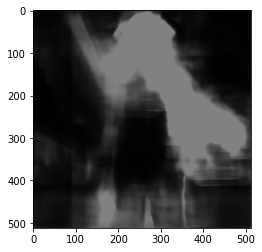

In [0]:
img_path = '/content/gdrive/My Drive/50c9nSeQkbE.jpg'

img_tensor = img_preproc(img_path)
img_tensor_grayscale = tf.image.rgb_to_grayscale(img_tensor, name=None)
img_tensor_grayscale.shape
result = model.predict(img_tensor_grayscale)
mask = predToGrayImage(result[0])
plt.imshow(mask)
plt.show()